# TECHNICAL REPORT: VRP with Genetic Algorithm (Initial Problem)

## 1. Introduction and Objectives

The main objective of this experiment is to solve a simplified version of the **Vehicle Routing Problem (VRP)** with capacity constraints (**CVRP**) using a **Genetic Algorithm (GA)**.

The VRP seeks to find the set of optimal routes for a fleet of vehicles departing from and returning to a depot to serve a set of customers. The goal is to **minimize the total distance traveled** by all vehicles, ensuring that the **load capacity** of each vehicle is not exceeded on any route.

**Specific Objectives:**

1.  **Model** the VRP with capacity constraints.
2.  **Implement** a Genetic Algorithm to find the best sequence of customers.
3.  **Evaluate** the quality of the solution (route) using the *fitness* function (total distance).
4.  **Analyze** the generated routes and their efficiency.

## 2. Experiment Design and Decisions

#### 2.1. Problem Representation

* **Customers:** 5 customers are defined with their coordinates $[x, y]$.
* **Depot:** A starting and ending point with fixed coordinates.
* **Demand:** Each customer's demand is calculated in weight (kg) based on a list of products and quantities.
* **Vehicle Capacity:** A fixed maximum capacity of **$60$ kg** is established.

#### 2.2. Preprocessing: Customer Classification

A crucial step of classifying customers into **valid** and **invalid** is performed:

* **Valid Customers:** Those whose individual demand is **less than or equal** to the vehicle's capacity.
* **Invalid Customers:** Those whose individual demand is **greater** than the capacity. These customers are excluded from the routing problem.

#### 2.3. Genetic Algorithm (GA) - Design Decisions

| Component | Design Decision | Explanation |
| :--- | :--- | :--- |
| **Chromosome (Individual)** | A list (permutation) of **valid customer indices**. | The *global* route is a complete sequence of customers to visit. |
| **Fitness Function** | $\text{fitness}(\text{route}) = \text{Total Distance}(\text{route})$ | **Minimize the total distance** traveled (Euclidean distance). |
| **Crossover Operator** | **Modified Order Crossover (OX)**. | A segment from parent 1 is kept and completed with elements from parent 2, ensuring validity (permutation without repetitions). |
| **Mutation Operator** | **Swap**. | Two random positions in the route are swapped with a **10% probability**. |
| **Parent Selection** | **Binary Tournament**. | Two random individuals are selected from the population, and the one with the **lowest** fitness (shortest route) is chosen for reproduction. |
| **Population Size** | **50 Individuals**. | A constant population of 50 possible routes is maintained in each generation. |
| **Stopping Criterion** | **200 Generations**. | The algorithm terminates after completing a fixed number of 200 iterations (generations). |
| **Routing** | **First-Fit Heuristic (Capacity-First)**. | The customer sequence is split into individual trips (routes) to the depot **whenever the accumulated load would exceed the vehicle's capacity**. |

The GA is used to optimize the **visiting sequence of valid customers**.

## 3. Experiment Execution

#### 3.1. Demand Data and Classification

| Original Customer | Calculated Total Demand (kg) | Classification |
| :---: | :---: | :---: |
| C1 | 18.6 | Valid |
| C2 | 22.8 | Valid |
| C3 | 48.0 | Valid |
| C4 | 60.0 | Valid |
| C5 | 77.7 | **Invalid** (> 60 kg) |

* **Valid Customers for GA:** 4 customers (indices 0, 1, 2, 3).

#### 3.2. Results (Example Run)

*(Note: GA results are stochastic and may vary with each execution.)*

* **Best Visit Order (Chromosome):** `[3, 0, 1, 2]` (Corresponds to sequence: C4, C1, C2, C3)
* **Best Total Distance:** $230.13$ (distance units)

#### 3.3. Route Division (According to Optimal Sequence)

The sequence `[3, 0, 1, 2]` is divided into trips respecting the $60$ kg limit:

1.  **Trip 1:** Serves customer 3 (C4). Load: 60.0 kg.
2.  **Trip 2:** Serves customers 0 and 1 (C1 and C2). Load: $41.4$ kg ($18.6 + 22.8$).
3.  **Trip 3:** Serves customer 2 (C3). Load: $48.0$ kg.

## 4. Analysis

#### 4.1. Solution Analysis

1.  **Constraint Handling:** Preprocessing that identifies Customer 5 as **Invalid** is essential, ensuring the GA only operates within a feasible solution space. The *fitness* function forces the creation of multiple trips (3 in this case) for the set of valid customers.
2.  **GA Efficiency:** By optimizing the **visit sequence**, the Genetic Algorithm manages to find an order that minimizes total distance while considering the 'interruptions' forced by capacity. It is observed that the GA prioritizes grouping low-demand customers (C1 and C2) and isolating the limit-demand customer (C4) in their own trip, which is logically efficient.
3.  **Fitness Function and Division Heuristic:** The fitness function intrinsically penalizes orders that force many long trips, as each trip implies two extra distance segments: **Depot $\rightarrow$ First Customer** and **Last Customer $\rightarrow$ Depot**. This directs the GA to search for sequences that allow multi-stop trips.

#### 4.2. Limitations

* **Simple Division Heuristic:** The `dividir_en_rutas` function uses a simple 'first-fit' strategy. In more complex problems, a smarter division that minimizes the distance of the *individual trip* could improve the solution.
* **Multi-Objective:** The solution only minimizes distance. A more complete VRP would also seek to **minimize the number of vehicles** (routes). The GA could be modified to include a penalty in the *fitness* for each additional route generated.

## 5. VRP and GA Code Implementation

Below is the code implementing the logic described in the report.

### VRP with Genetic Algorithm
Notebook organized into multiple cells for better readability.

### 5.1. Library Import
This section includes the necessary libraries to implement the genetic algorithm and auxiliary functions.

In [1]:
import random
import math
import matplotlib.pyplot as plt

### 5.2. Problem Data
Coordinates for the depot and customers, product weights, and customer orders are established.

In [2]:
# Depot coordinates
depot = [20, 120]

# Customer coordinates
customers = [
    [35, 115],
    [50, 140],
    [70, 100],
    [40, 80],
    [25, 60]
]

# Product weights (kg)
weights = [1.2, 3.8, 7.5, 0.9, 15.4, 12.1, 4.3, 19.7, 8.6, 2.5]

# Customer orders: (product_id, quantity)
orders = [
    [(3, 2), (1, 3)],
    [(2, 6)],
    [(7, 4), (5, 2)],
    [(3, 8)],
    [(6, 5), (9, 2)]
]

# PARAMS
N_GEN = 200
POP_SIZE = 50
PM = 0.1

print('Data loaded successfully.')

Data loaded successfully.


### 5.3. Demand Calculation
Total demand for each customer is calculated by summing the weight of ordered products.

In [3]:
demands = []
for order in orders:
    # Calculate total weight for the order based on product weights
    total = sum(weights[item - 1] * qty for item, qty in order)
    demands.append(total)

capacity = 60
print('Calculated demands:', [round(x, 1) for x in demands])

Calculated demands: [18.6, 22.8, 48.0, 60.0, 77.7]


### 5.4. Classification of Valid / Invalid Customers (Preprocessing)

In [4]:
valid_customers = []
valid_demands = []
invalid_customers = []
invalid_demands = []

for i in range(len(customers)):
    if demands[i] <= capacity:
        # Save valid customer. The index corresponds to the position in the valid list.
        # For GA simplicity, we only store coordinates for distance calculation and their demands.
        valid_customers.append(customers[i])
        valid_demands.append(demands[i])
    else:
        invalid_customers.append(customers[i])
        invalid_demands.append(demands[i])

print('Valid customers:', len(valid_customers))
print('Valid demands:', [round(d, 1) for d in valid_demands])
print('Invalid customers:', len(invalid_customers))
print('Invalid demands:', [round(d, 1) for d in invalid_demands])

Valid customers: 4
Valid demands: [18.6, 22.8, 48.0, 60.0]
Invalid customers: 1
Invalid demands: [77.7]


### 5.5. Auxiliary Functions (Fitness)
These are helper functions used by the fitness function to evaluate each solution of the genetic algorithm.

In [5]:
def distance(a, b):
    """Calculates Euclidean distance between two points."""
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def split_into_routes(route):
    """Divides the global sequence (chromosome) into valid routes by capacity (First Fit Heuristic)."""
    routes = []
    load = 0
    current_route = []
    for c in route:
        # c is the index of the valid customer (0 to n-1)
        if load + valid_demands[c] <= capacity:
            current_route.append(c)
            load += valid_demands[c]
        else:
            # Capacity exceeded: current route ends, new one begins.
            routes.append(current_route)
            current_route = [c]
            load = valid_demands[c]
    if current_route:
        # Add the last route if it exists
        routes.append(current_route)
    return routes

def total_distance(route):
    """Calculates total distance of all trips generated from the route (chromosome)."""
    routes = split_into_routes(route)
    total = 0
    for r in routes:
        pos = depot # Start at depot
        for c in r:
            # Distance from previous point to customer c
            total += distance(pos, valid_customers[c])
            pos = valid_customers[c]
        # Return distance to depot
        total += distance(pos, depot)
    return total

def fitness(route):
    """Fitness is the total distance (we seek to minimize it)."""
    return total_distance(route)

print('Auxiliary functions (distance, route division, and fitness) defined.')

Auxiliary functions (distance, route division, and fitness) defined.


### 5.6. Genetic Operators
Genetic operators define how new solutions are created in each generation:

- Creation: creates an initial population of n random routes.

- Selection: chooses best individuals with lower fitness.

- Crossover: combines two parents to generate offspring maintaining customer order (OX).

- Mutation: introduces small variations by swapping.

In [6]:
def create_population(n, num_customers):
    """Creates an initial population of n random routes."""
    population = []
    base = list(range(num_customers))
    for _ in range(n):
        r = base[:]
        random.shuffle(r)
        population.append(r)
    return population

def tournament_selection(population, fitness_values):
    """Selection by binary tournament (chooses the individual with lower fitness)."""
    i1, i2 = random.sample(range(len(population)), 2)
    return population[i1][:] if fitness_values[i1] < fitness_values[i2] else population[i2][:]

def crossover(p1, p2):
    """Order Crossover (OX) modified to maintain chromosome validity."""
    a, b = sorted(random.sample(range(len(p1)), 2))
    child = [-1] * len(p1)
    child[a:b] = p1[a:b]
    pos = b
    for x in p2:
        if x not in child:
            if pos >= len(p1): pos = 0
            child[pos] = x
            pos += 1
    return child

def mutation(route, prob=PM):
    """Mutation by swap with a given probability."""
    if random.random() < prob:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]

print('Genetic operators ready.')

Genetic operators ready.


### 5.7. Main Genetic Algorithm
This is the core of the GA that seeks, generation after generation, to minimize the total distance of routes while respecting vehicle capacity.

In [7]:
def genetic_algorithm(n_generations=N_GEN, pop_size=POP_SIZE):
    """Main loop of the Genetic Algorithm."""
    num_customers = len(valid_customers)
    if num_customers == 0:
        return [], 0
        
    population = create_population(pop_size, num_customers)
    fitness_values = [fitness(r) for r in population]

    for gen in range(n_generations):
        new_population = []
        for _ in range(pop_size):
            p1 = tournament_selection(population, fitness_values)
            p2 = tournament_selection(population, fitness_values)
            child = crossover(p1, p2)
            mutation(child, 0.1)
            new_population.append(child)
        population = new_population
        fitness_values = [fitness(r) for r in population]

    best_idx = min(range(pop_size), key=lambda i: fitness_values[i])
    return population[best_idx], fitness_values[best_idx]

print('Genetic algorithm configured.')

Genetic algorithm configured.


### 5.8. Execution and Results

In this section, the algorithm results are displayed.

In [8]:
best_route, best_value = genetic_algorithm()

print("Visit Order (Indices of valid customers):")
print(best_route)
print("Total Distance:", round(best_value, 2))

print("\nTrip Details:")
routes = split_into_routes(best_route)
for i, r in enumerate(routes):
    load = sum(valid_demands[c] for c in r)
    print(f"Trip {i+1}: {r} (Load {round(load, 1)} kg)")

Visit Order (Indices of valid customers):
[2, 3, 0, 1]
Total Distance: 278.17

Trip Details:
Trip 1: [2] (Load 48.0 kg)
Trip 2: [3] (Load 60.0 kg)
Trip 3: [0, 1] (Load 41.4 kg)


### 5.9. Final Visualization

This section shows a plot with the routes, the depot, weights, and customers.

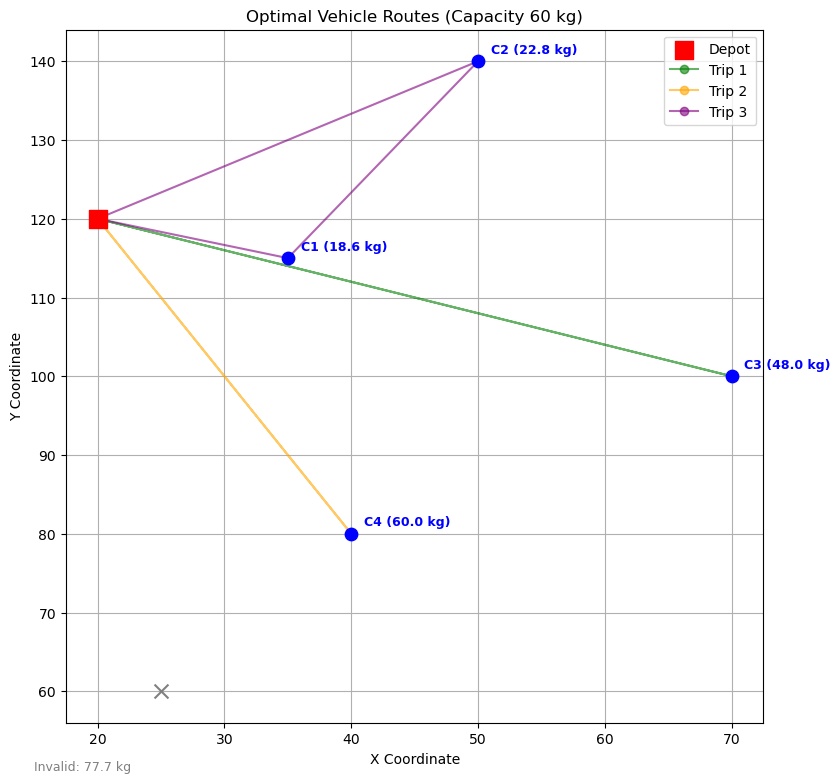

In [9]:
def plot_routes(routes):
    """Generates the plot of routes, depot, and customers."""
    plt.figure(figsize=(9, 9))
    
    # Valid Customers
    for i, (x, y) in enumerate(valid_customers):
        plt.scatter(x, y, c='blue', s=80, zorder=5)
        plt.text(x+1, y+1, f'C{i+1} ({round(valid_demands[i], 1)} kg)', fontsize=9, color='blue', fontweight='bold')
        
    # Depot
    plt.scatter(depot[0], depot[1], c='red', s=150, marker='s', label='Depot', zorder=6)

    colors = ['green', 'orange', 'purple', 'cyan', 'brown']

    # Route Plotting
    for i, r in enumerate(routes):
        points = [depot] + [valid_customers[c] for c in r] + [depot]
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        plt.plot(xs, ys, '-o', color=colors[i % len(colors)], alpha=0.6, label=f'Trip {i+1}')
        
    # Invalid Customers (Excluded)
    for (x, y) in invalid_customers:
        # Find original index to get demand (checking against original list)
        idx = customers.index([x, y]) 
        inv_demand = demands[idx]
        plt.scatter(x, y, c='gray', marker='x', s=100, zorder=4)
        plt.text(x-10, y-10, f'Invalid: {round(inv_demand, 1)} kg', fontsize=9, color='gray')

    plt.title("Optimal Vehicle Routes (Capacity 60 kg)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

if best_route:
    # We must recalculate routes from the best sequence to plot them
    final_routes = split_into_routes(best_route)
    plot_routes(final_routes)
else:
    print("No valid customers to plot.")

## 6. Final Experiment Conclusions

After executing the genetic algorithm with a capacity constraint of **60 kg**, the following conclusions are drawn:

1.  **Demand Loss (Invalid Customer):**
    * The system correctly identified that **Customer 5** has a demand of **77.7 kg**, which exceeds the maximum vehicle capacity.
    * **Conclusion:** It is impossible to satisfy this customer's demand with the current fleet. This represents a significant service loss and suggests the need for larger vehicles or allowing partial deliveries (splitting the order into two trips).

2.  **Fleet Efficiency (Underutilization):**
    * To serve the remaining 4 valid customers, the algorithm generated **3 trips**.
    * *Trip with C4 (60 kg):* 100% occupancy. Very efficient.
    * *Trip with C3 (48 kg):* 80% occupancy. With only 12 kg free, C1 (18.6 kg) or C2 (22.8 kg) could not be added, forcing a new trip.
    * **Conclusion:** The 60 kg constraint causes high route fragmentation. Many return trips to the depot are required, increasing total distance and operating costs.
    
3.  **Genetic Algorithm Performance:**
    * The GA managed to find a permutation that minimizes distance given the constraints, effectively grouping small customers (C1 and C2) where possible.
    * However, the quality of the logistical solution is strongly limited by the physical capacity of the vehicle, not by the algorithm's optimization.